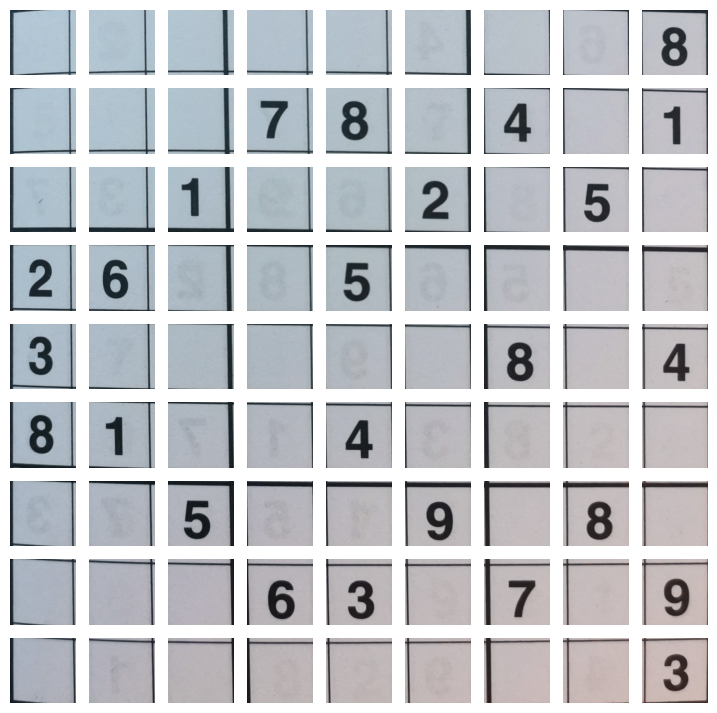

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(img, (9, 9), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges

def find_largest_contour(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def warp_perspective(img, contour):
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4:
        points = approx.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        s = points.sum(axis=1)
        rect[0] = points[np.argmin(s)]
        rect[2] = points[np.argmax(s)]
        diff = np.diff(points, axis=1)
        rect[1] = points[np.argmin(diff)]
        rect[3] = points[np.argmax(diff)]
        (tl, tr, br, bl) = rect
        width = max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl))
        height = max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl))
        dst = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]], dtype="float32")
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(img, M, (int(width), int(height)))
        return warped
    else:
        raise Exception("La grille n'a pas été détectée correctement.")

def extract_cells(warped, grid_size=9):
    cells = []
    cell_height, cell_width = warped.shape[0] // grid_size, warped.shape[1] // grid_size
    for i in range(grid_size):
        row = []
        for j in range(grid_size):
            cell = warped[i*cell_height:(i+1)*cell_height, j*cell_width:(j+1)*cell_width]
            row.append(cell)
        cells.append(row)
    return cells

def main(image_path):
    edges = preprocess_image(image_path)
    largest_contour = find_largest_contour(edges)
    img = cv2.imread(image_path)
    warped = warp_perspective(img, largest_contour)
    cells = extract_cells(warped)
    return cells

# Exemple d'utilisation
image_path = "sudoku_photo.jpg"
cells = main(image_path)

# Afficher chaque cellule dans leur configuration d'origine
fig, axs = plt.subplots(9, 9, figsize=(9, 9))
for i in range(9):
    for j in range(9):
        axs[i, j].imshow(cells[i][j], cmap='gray')
        axs[i, j].axis('off')
plt.show()


In [8]:
import os

# Répertoire contenant les images
image_dirs = {
    "train": "dataset_number/images/train",
    "val": "dataset_number/images/val",
}

# Dictionnaire pour mapper les noms de dossiers aux classes
class_map = {"2": 1, "3": 2, "4": 3, "5": 4, "6": 5, "7": 6, "8": 7, "9": 8, "0": 9}

# Créer les annotations
for split, image_dir in image_dirs.items():
    label_dir = f"dataset_number/labels/{split}"
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    for folder in os.listdir(image_dir):
        class_id = class_map[folder[5]]
        folder_path = os.path.join(image_dir, folder)

        for img_file in os.listdir(folder_path):
            if img_file.endswith(".png"):
                annotation_path = os.path.join(
                    label_dir, img_file.replace(".png", ".txt")
                )
                with open(annotation_path, "w") as f:
                    # Annotation standardisée pour un chiffre centré
                    f.write(f"{class_id} 0.5 0.5 0.8 0.8\n")
                # Déplacer l'image dans le répertoire principal
                os.rename(
                    os.path.join(folder_path, img_file),
                    os.path.join(image_dir, img_file),
                )

# Nettoyer les anciens répertoires
for split in image_dirs:
    for folder in class_map:
        folder_path = os.path.join(image_dirs[split], folder)
        if os.path.exists(folder_path):
            os.rmdir(folder_path)

NotADirectoryError: [Errno 20] Not a directory: 'dataset_number/images/train/img009-00774.png'

In [10]:
# Importer les bibliothèques nécessaires
import os
from ultralytics import YOLO

# Chemins vers le dataset et le fichier de configuration du modèle
data_yaml = 'model_number.yaml'
model_config = 'yolov8n.pt'  # Remplacer par la version de votre modèle si différent

# Charger le modèle
model = YOLO(model_config)

# Entraîner le modèle
model.train(data=data_yaml, epochs=3, batch=16, imgsz=640)


New https://pypi.org/project/ultralytics/8.3.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.48 🚀 Python-3.12.3 torch-2.5.1+cu124 CPU (13th Gen Intel Core(TM) i9-13900H)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=model_number.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train24, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning /home/erwan/Documents/TPS/2A/sudoku_python/dataset_number/labels/train.cache... 7200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7200/7200 [00:00<?, ?it/s]
val: Scanning /home/erwan/Documents/TPS/2A/sudoku_python/dataset_number/labels/val.cache... 1800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1800/1800 [00:00<?, ?it/s]

Plotting labels to runs/detect/train24/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train24
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G     0.9544      2.413      1.523         36        640: 100%|██████████| 450/450 [21:55<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [02:10<00:00,  2.28s/it]

                   all       1800       1800      0.922      0.898      0.963      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G     0.7088      1.329      1.294         41        640: 100%|██████████| 450/450 [20:47<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [01:56<00:00,  2.05s/it]

                   all       1800       1800      0.953      0.939      0.984      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G     0.6147       1.03      1.219         43        640: 100%|██████████| 450/450 [20:21<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [01:57<00:00,  2.06s/it]

                   all       1800       1800      0.968      0.972      0.992      0.901



3 epochs completed in 1.153 hours.
Optimizer stripped from runs/detect/train24/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train24/weights/best.pt, 6.2MB

Validating runs/detect/train24/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.12.3 torch-2.5.1+cu124 CPU (13th Gen Intel Core(TM) i9-13900H)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [01:44<00:00,  1.84s/it]


                   all       1800       1800      0.968      0.972      0.992      0.901
                     1        200        200      0.901      0.995      0.991       0.89
                     2        200        200          1      0.938      0.993      0.892
                     3        200        200      0.962      0.955      0.989      0.918
                     4        200        200          1      0.969      0.995      0.886
                     5        200        200      0.949      0.945      0.987      0.912
                     6        200        200      0.993       0.98      0.993      0.963
                     7        200        200      0.952      0.991      0.993      0.896
                     8        200        200      0.968       0.99      0.994      0.871
                     9        200        200       0.99       0.99      0.995       0.88
Speed: 0.6ms preprocess, 55.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detec

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79c17ce003e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [11]:
model_path = "models/yolov8n_number.pt"
model.save(model_path)